# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 1 — Setting Up


---

Submission by:
* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* Michelle, Schlicher, Matrikelnummer: 5889471

In [2]:
from io import StringIO

import pandas as pd
import requests
from jax import numpy as jnp # https://github.com/cloudhan/jax-windows-builder
from matplotlib import pyplot as plt
from matplotlib import ticker

from tueplots import bundles
from tueplots.constants.color import rgb

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

# Exercise 1.2 (Coding Exercise)

This week's exercise serves as an opener for the course. As a first step, make sure the cell above this works for you. This is mostly to ensure you have `jax` and `tueplots` installed in your local environment, which we will use across the course. If you get errors, try a `pip install jax tueplots pandas`. Consider the well-known Mauna Loa CO$_2$ dataset, which we download directly from [NOAA](https://gml.noaa.gov/ccgg/trends/data.html): 

In [3]:
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"
s = requests.get(url).text

df = pd.read_csv(StringIO(s), sep=",", header=51, na_values="-999.99").dropna()
X = df["decimal"]
Y = df["average"]

We do a *very* quick and dirty linear regression on this univariate timeseries.

In [4]:
phi = jnp.stack([jnp.ones(len(X)), jnp.asarray(X)])
w = jnp.linalg.solve((phi @ phi.T), phi @ Y)
Ypred_LinReg = w[0] + w[1] * X


def loss(Yhat):
    return jnp.sqrt(((Y - Yhat) ** 2).mean())


print(f"simple linear regression has train RMSE {loss(Ypred_LinReg):0.2f}")

simple linear regression has train RMSE 3.08


And make a nice plot:

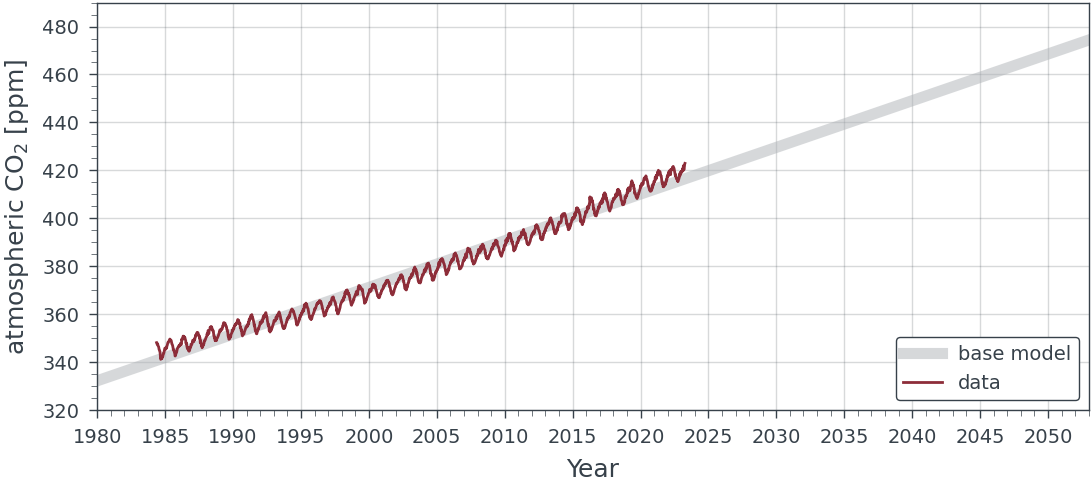

In [5]:
fig, ax = plt.subplots()
x = jnp.linspace(1980, 2053, 200)
ax.plot(x, w[0] + w[1] * x, color=rgb.tue_gray,
        lw=4, alpha=0.5, label="base model")
ax.plot(X, Y, label="data")

ax.set_xlabel("Year")
ax.set_ylabel("atmospheric CO$_2$ [ppm]")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim([1980, 2053])
ax.set_ylim([320, 490])
ax.grid(which="major", axis="both")
ax.legend(loc="lower right", framealpha=1, facecolor="w");

## Your Task:

Using your favorite deep learning framework, define and train a supervised (regression) model on this dataset `X,Y`. Use it to predict on the test inputs `x = jnp.linspace(1980, 2053, 200)` from above, i.e. 30 years into the future. Consider the following aspects:
* Does your model interpolate between the data (i.e. does it predict the actual pairs $(x_i,y_i)$ correctly, or just approximately)?
* Which structural aspects of the data does your model capture (e.g., does its extrapolation also capture the seasonal oscillations present in the data?
* Do you know a way to add a form of *confidence* or *uncertainty* to the prediction? Can you make *worst/best-case* and *most likely* predictions for atmospheric CO$_2$ over the next 30 years?

**Note:** There is obviously no unique "correct" answer to this task. The goal of this exercise is to allow you to reflect on what you may have heard in previous courses about state-of-the-art machine learning models and their training. Deep learning is often perceived as having replaced all of machine learning, and it certainly permeates most of it. However, while deep learning models have led to impressive results on applications like natural language processing and computer vision, they remain nontrivial to train and to interpret; and their extrapolatory behaviour can be underwhelming. Much of the lecture course will be dedicated to understanding models, their training and predictive behaviour better, and to transfer much of what we learn with basic models to deep learning. 

Thus, we do not expect you to provide a perfect answer here. Answers will get the "sufficient" mark (i.e. the associated bonus point in the exam) if they 
* correctly define any model with at least one nonlinearity
* train the model such that its RMSE on the train set (as defined above) is *smaller* than that of linear regression. 
* amend the plot above with the model's prediction on the testset `x` (not the train set!)

In [53]:
df_reduced = pd.concat([X,Y], axis=1)
df_reduced = df_reduced.reset_index(drop=True)
df_reduced['y'] = df_reduced['average'].shift(-1)

### Baseline Model ###
 # train test split / 90:10
train = df_reduced[:-100]
test = df_reduced[-100:]
test = test.drop(test.tail(1).index)
test = test.copy()

X_train = train['average'].values.reshape(-1,1)
y_train = train['y']
X_test = test['average'].values.reshape(-1,1)
y_test = test['y']

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

df_reduced['pred'] = regr.predict(df_reduced['average'].values.reshape(-1,1))
loss_train = jnp.sqrt(((df_reduced['y']- df_reduced['pred']) ** 2).mean())
print(f"simple MLP Regressor has train RMSE {loss_train:0.2f}") 

simple MLP Regressor has train RMSE 0.58


In [59]:
### using multiple timepoints for prediction ###
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['average'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['average'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

# use five timesteps
df_2 = window_input(5, pd.concat([X,Y], axis=1))

X_2 = df_2[['average', 'x_1', 'x_2', 'x_3', 'x_4']].values
y_2 = df_2['y'].values

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42, shuffle=False)
regr_2 = MLPRegressor(random_state=1, max_iter=500).fit(X_train_2, y_train_2)
df_2['pred'] = regr_2.predict(X_2)
loss_train_2 = jnp.sqrt(((df_2['y']- df_2['pred']) ** 2).mean())
print(f"MLP Regressor has train RMSE {loss_train_2:0.2f}") 

MLP Regressor has train RMSE 1.10


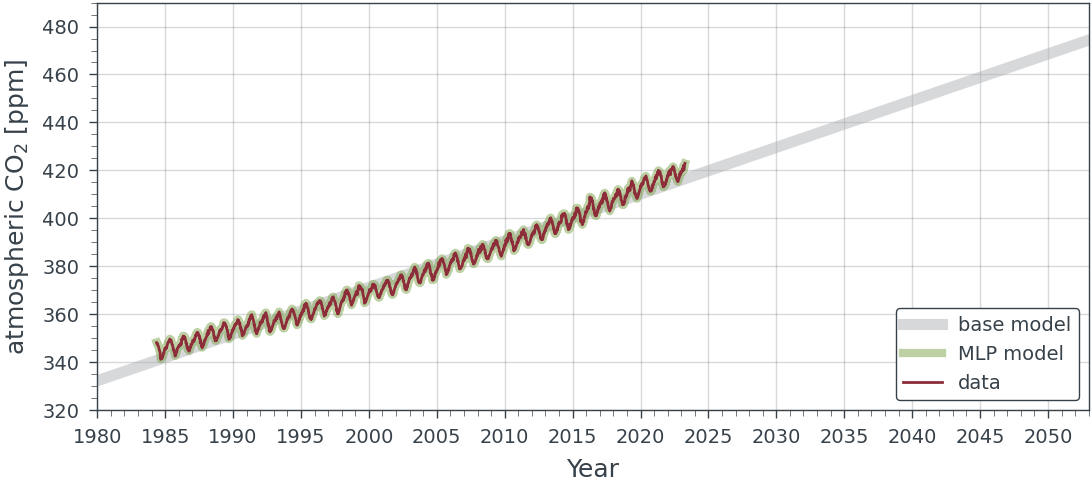

In [45]:
fig, ax = plt.subplots()
x = jnp.linspace(1980, 2053, 200)
ax.plot(x, w[0] + w[1] * x, color=rgb.tue_gray,
        lw=4, alpha=0.5, label="base model")
ax.plot(X, df_reduced['pred'], color=rgb.tue_green,
        lw=3, alpha=0.5, label="MLP model")
ax.plot(X, Y, label="data")

ax.set_xlabel("Year")
ax.set_ylabel("atmospheric CO$_2$ [ppm]")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim([1980, 2053])
ax.set_ylim([320, 490])
ax.grid(which="major", axis="both")
ax.legend(loc="lower right", framealpha=1, facecolor="w");

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matricel number(s) above!)**